In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control as ctrl
import sympy as sp



1. *Função de Transferência $G_{vd}(s)$*:
   - Representa a relação entre a variação na tensão de saída ($\hat{v}_o(s)$) e a variação na razão cíclica $d(s)$, mantendo a tensão de entrada $v_i(s)$ constante.
   - Fórmula:
\
   $G_{vd}(s) = \frac{V_i}{L_o C_o s^2 + \frac{L_o}{R_o} s + 1}$

   Onde $V_i$ é a tensão de entrada, $D$ é a razão cíclica, $L_o$ é a indutância, $C_o$ é a capacitância e $R_o$ é a resistência.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


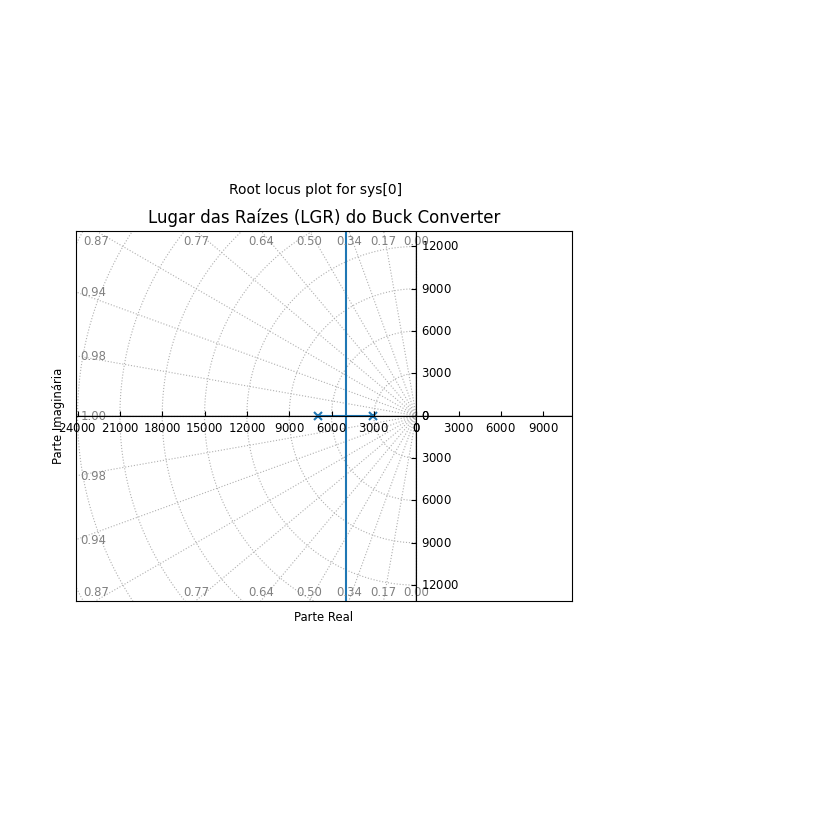

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Parâmetros do seu Buck
Vin = 15                  # Tensão de entrada (V)
Vout = 2                 # Tensão de saída (V)
Iout = 2                # Corrente de saída (A)
Rload = Vout / Iout       # Carga equivalente (Ω)
L = 470e-6                # Indutor (uH)
C = 100e-6               # Capacitor de saída (uF)

# Função de transferência da planta do Buck (sem compensador)
# Gvd(s) = Vin / (L*C*s^2 + (L/R)*s + 1)
num = [Vin]
den = [L*C, L/Rload, 1]
G_plant = ctrl.TransferFunction(num, den)



# Opcional: adicionar compensador tipo 2 simples (PI com roll-off)
# C(s) = K * (1 + s/wz) / (1 + s/wp)
# Descomente e edite abaixo se quiser testar com compensador:
# wz = 2 * np.pi * 200   # zero em 200 Hz
# wp = 2 * np.pi * 5000  # pólo em 5 kHz
# K = 10
# num_c = [K / wz, K]
# den_c = [1 / wp, 1]
# C = ctrl.TransferFunction(num_c, den_c)
# G_open = G_plant * C

# Para LGR só da planta (sem compensador):
G_open = G_plant

# Gráfico do Lugar das Raízes
plt.figure()
ctrl.root_locus(G_open, grid=True)
plt.title("Lugar das Raízes (LGR) do Buck Converter")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.grid(True)
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


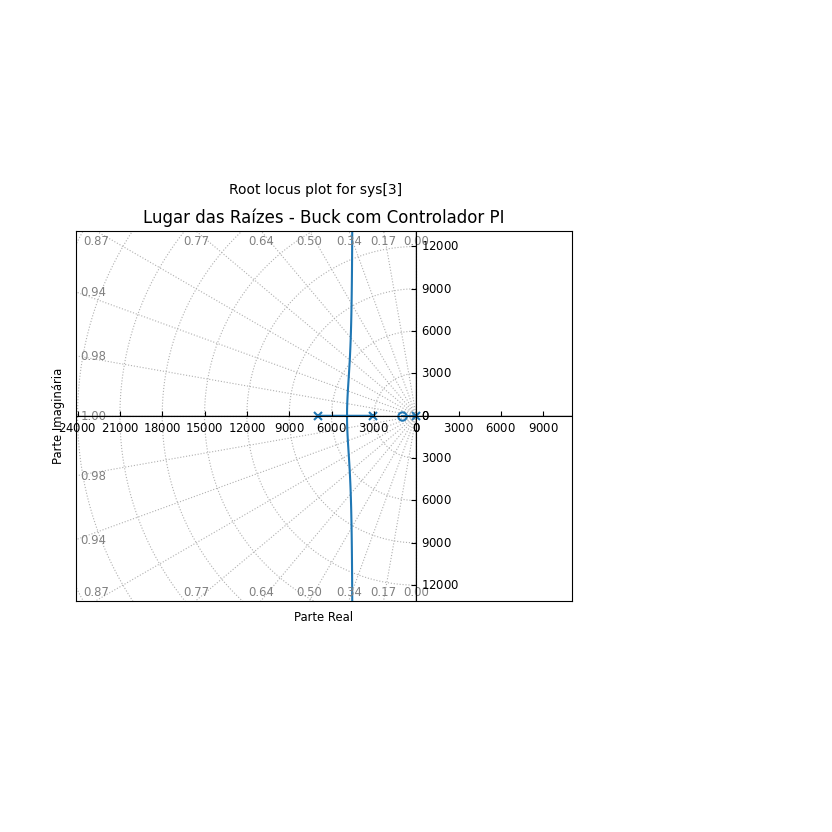

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Planta do Buck
# Vin = 12
# Vout = 5
# Iout = 2
# Rload = Vout / Iout
# L = 820e-6
# C = 100e-6

# Função de transferência da planta: Gvd(s)
num_plant = [Vin]
den_plant = [L * C, L / Rload, 1]
G_plant = ctrl.TransferFunction(num_plant, den_plant)

# Controlador PI: C(s) = Kp + Ki/s = (Kp*s + Ki) / s
Kp = 0.01      # Ganho proporcional
Ki = 10    # Ganho integral
num_PI = [Kp, Ki]
den_PI = [1, 0]
C_PI = ctrl.TransferFunction(num_PI, den_PI)

# Malha aberta com PI
G_open_PI = C_PI * G_plant

# LGR
plt.figure()
ctrl.root_locus(G_open_PI, grid=True)
plt.title("Lugar das Raízes - Buck com Controlador PI")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.grid(True)
plt.show()

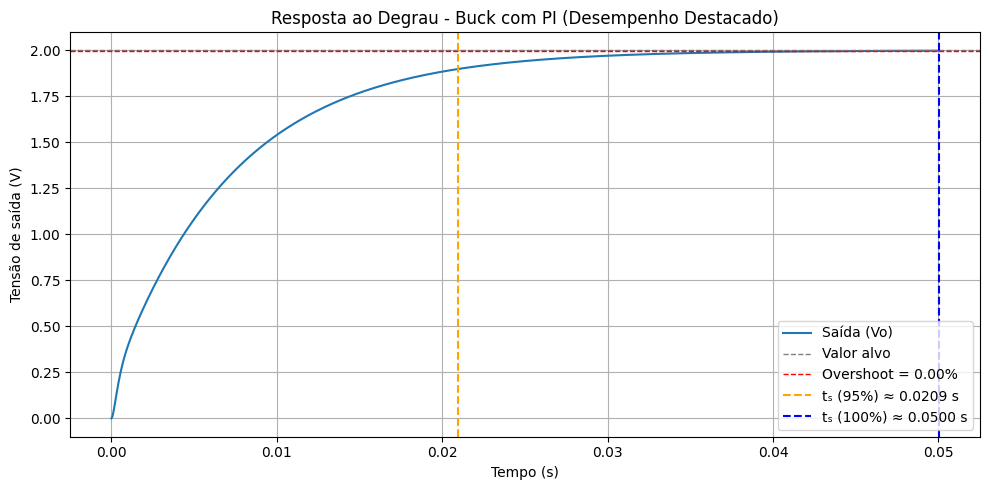

Overshoot: 0.00%
Tempo de subida (→ 95%): 0.0207 s
Tempo de subida (→ 100%): 0.0498 s
Erro em regime permanente: 0.0018 V


In [5]:

# === Parâmetros  ===
# Vin = 24       # tensão de entrada
# Vout = 12      # tensão de saída desejada
# L = 820e-6     # indutância
# C = 440e-6    # capacitância
# Rload = 2.5      # carga resistiva (por exemplo)
# Kp = 0.01
# Ki = 3

# === Função de Transferência Gvd(s) ===
num_plant = [Vin]
den_plant = [L*C, L/Rload, 1]
G_plant = ctrl.TransferFunction(num_plant, den_plant)

# === Controlador PI ===
num_PI = [Kp, Ki]
den_PI = [1, 0]
C_PI = ctrl.TransferFunction(num_PI, den_PI)

# === Malha fechada ===
G_open = C_PI * G_plant
G_closed = ctrl.feedback(G_open, 1)

# === Resposta ao degrau ===
t, y = ctrl.step_response(G_closed)
y = y * Vout  # Escala para 12 V reais

# === Métricas ===
Vfinal = y[-1]
overshoot = (np.max(y) - Vfinal) / Vfinal * 100

# Tempo de subida: entre 5% e 95% ou 100%
t_5 = t[np.where(y >= 0.05 * Vfinal)[0][0]]
t_95 = t[np.where(y >= 0.95 * Vfinal)[0][0]]
t_100 = t[np.where(y >= 1.00 * Vfinal)[0][0]]

tr_95 = t_95 - t_5
tr_100 = t_100 - t_5

ess = np.abs(Vout - y[-1])  # erro em regime

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(t, y, label="Saída (Vo)")
plt.axhline(Vout, color='gray', linestyle='--', linewidth=1, label="Valor alvo")
plt.axhline(np.max(y), color='r', linestyle='--', linewidth=1, label=f"Overshoot = {overshoot:.2f}%")

plt.axvline(t_95, color='orange', linestyle='--', label=f"tₛ (95%) ≈ {t_95:.4f} s")
plt.axvline(t_100, color='blue', linestyle='--', label=f"tₛ (100%) ≈ {t_100:.4f} s")

plt.title("Resposta ao Degrau - Buck com PI (Desempenho Destacado)")
plt.xlabel("Tempo (s)")
plt.ylabel("Tensão de saída (V)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Impressão dos dados ===
print(f"Overshoot: {overshoot:.2f}%")
print(f"Tempo de subida (→ 95%): {tr_95:.4f} s")
print(f"Tempo de subida (→ 100%): {tr_100:.4f} s")
print(f"Erro em regime permanente: {ess:.4f} V")
